# DeepForest - ESA Stats Seminar 2025

The aim of this tutorial is to demonstrate the use of the DeepForest package for object detection in aerial imagery. We will work today to identify birds in drone images. DeepForest docs are here! 

https://deepforest.readthedocs.io

1. Load a model
2. Split the orthomosaic into tiles
3. Predict on the tiles
4. Merge the predictions
5. Visualize the results
6. Split train-test
7. Evaluate the results

# Download data


In [25]:
import requests
import zipfile
import io
import os   

# Check if files already exist in data directory
if os.path.exists("data/DeepWaterHorizon") and os.path.exists("data/DeepWaterHorizon"):
    print("Files already downloaded:")
    for f in os.listdir("data"):
        print(f"- {f}")
else:

    # Download zip file from Dropbox
    url = "https://www.dropbox.com/scl/fo/p7mm97e9xo7a3gqtcs1cd/ANQ_YnFlOhkP-t7hc8At3_k?rlkey=c4eik22p4m1t1q4wct0cnk7ra&dl=1"
    response = requests.get(url)

    # Create data directory if it doesn't exist
    os.makedirs("data", exist_ok=True)

    # Extract zip contents
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall("data")
        
    # Get list of extracted files
    files = os.listdir("data")
    print("Downloaded files:")
    for f in files:
        print(f"- {f}")


Files already downloaded:
- .DS_Store
- temp_test.csv
- DeepWaterHorizon
- crops
- temp_train.csv


## Load a model

DeepForest comes with several prebuilt models, for trees, birds, livestock, and other custom projects. We are open to creating and hosting more models based on the community needs.

In [26]:
from deepforest import main
import os
model = main.deepforest()
model.load_model("weecology/deepforest-bird")

Reading config file: /Users/benweinstein/.conda/envs/DoubleCounting/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


# Make initial predictions and view

We always think of DeepForest as the starting place for model development. The model is note intended to be used as a zero-shot tool. we expect that the model will be trained on a small dataset and then used to make predictions on a larger dataset. 

In [ ]:
from deepforest import visualize
import glob
images = glob.glob("data/DeepWaterHorizon/*")
# Make predictions on the first 4 images
for image in images[:4]:
    predictions = model.predict_image(path=image)
    visualize.plot_results(predictions)

These images show adequate results, but can be improved with local annotations

## Annotate data in target imagery

We use label-studio to annotate data in target imagery. Data can be exported as pascal voc or COCO format. 

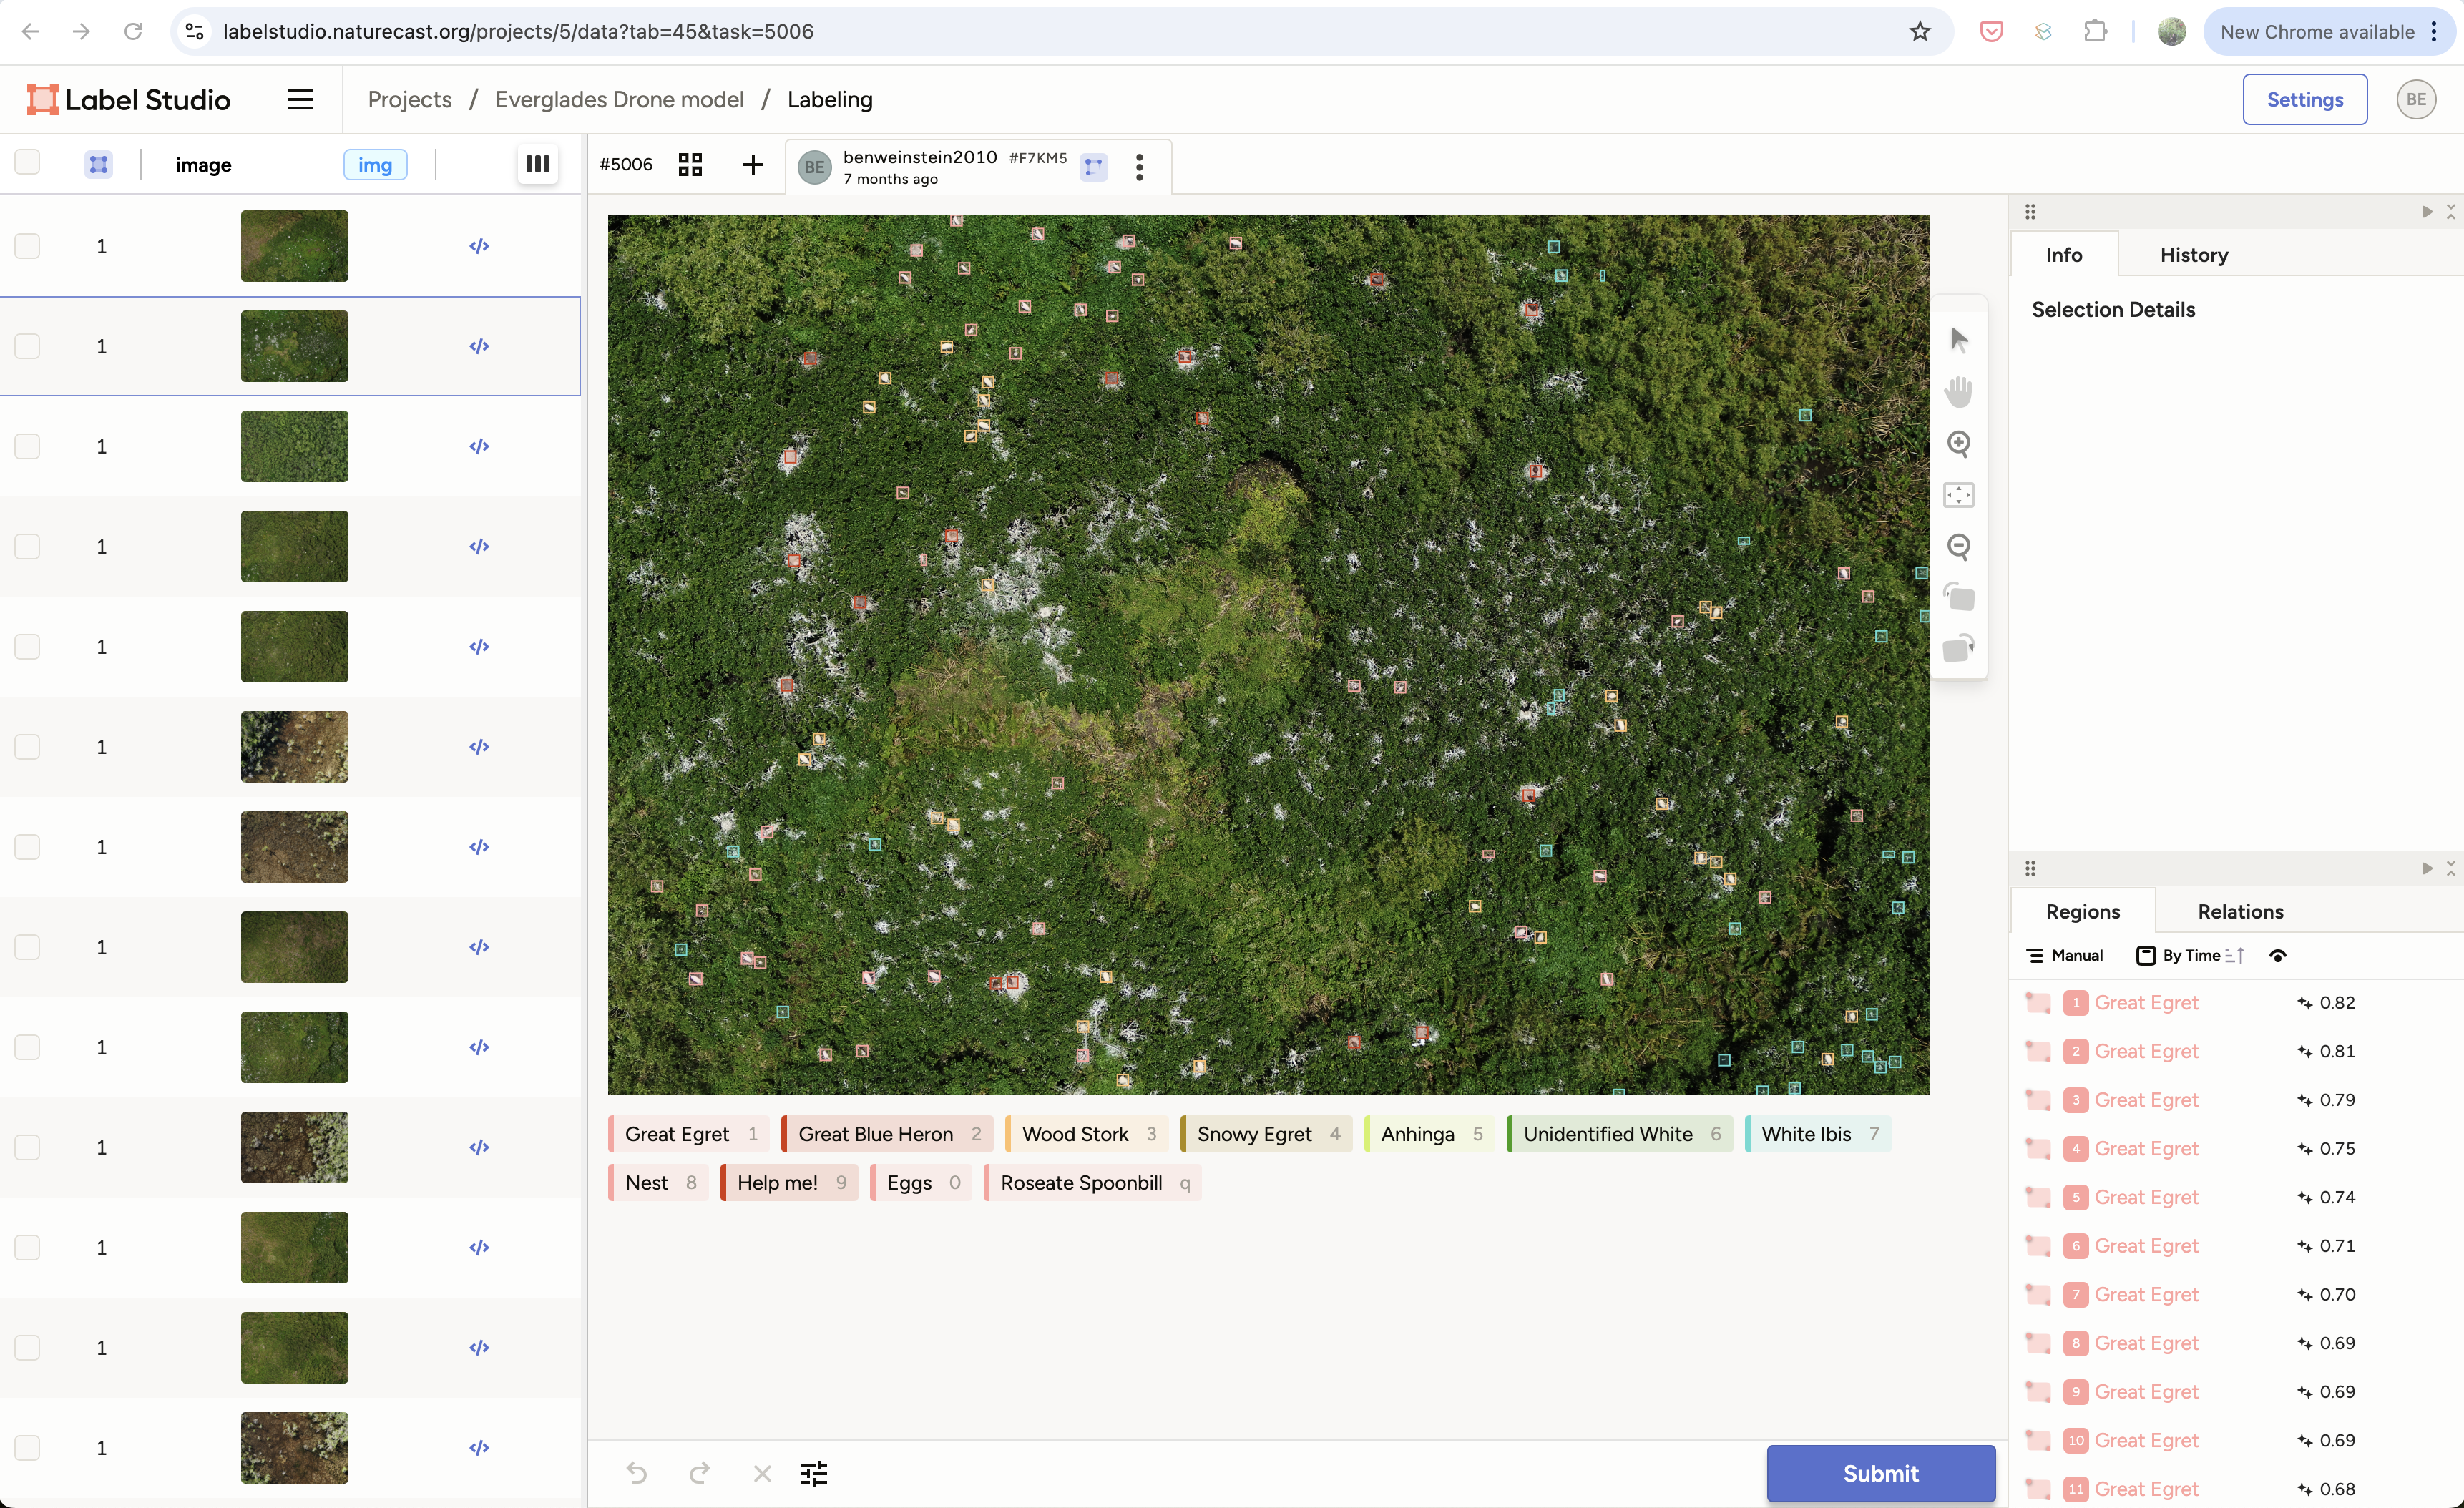

## Load annotations
The deepforest.utilities.read_file function can load csv, shapefiles, or xml formats. 

In [ ]:
from deepforest.utilities import read_file
from deepforest import visualize

annotations = read_file("data/DeepWaterHorizon/annotations.csv")
annotations.head()

# plot one image with annotations
image = "data/DeepWaterHorizon/20240715_140000_0000_RGB.tif"
image_annotations = annotations[annotations.image_path == annotations.image_path.unique()[0]]
image_annotations.root_dir = "data/DeepWaterHorizon"
visualize.plot_results(image_annotations)


## Optionally split the annotations into train and test

We believe the training data should have biological meaning. Random splits are not recommended. Instead, we recommend splitting data as you actually want to use it, accross survey effects or time, or species. 

### Simple fine-tune example

In [ ]:
%timeit

model.config["train"]["csv_file"] = "data/DeepWaterHorizon/annotations.csv"
model.config["train"]["root_dir"] = "data/DeepWaterHorizon"
model.config["train"]["epochs"] = 1
model.config["train"]["lr"] = 0.0001

# Train model
model.create_trainer(max_steps=5)
model.trainer.fit(model)

# How many annotations do we need? 

Let's write a loop to split the train test data, fit the model, and evaluate the results. 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

def evaluate_model_splits(model, annotations_df, root_dir, train_fractions=[0.01, 0.1, 0.2, 0.5], epochs=1):
    """
    Evaluate model performance across different train-test splits.
    
    Args:
        model: DeepForest model instance
        annotations_df: DataFrame with annotations
        root_dir: Directory containing images
        train_fractions: List of training set fractions to evaluate
        epochs: Number of training epochs per split
    
    Returns:
        DataFrame with evaluation metrics for each split
    """
    # Get unique image names
    unique_images = annotations_df['image_path'].unique()
    results = []

    # 10 test images
    test_images = unique_images[int(len(unique_images) * 0.1):]
    train_images = unique_images[:int(len(unique_images) * 0.9)]

    
    for fraction in train_fractions:
        # Split images into train and test sets
        train_images = train_images[:int(len(train_images) * fraction)] 
        
        # Create train and test annotation dataframes
        train_df = annotations_df[annotations_df['image_path'].isin(train_images)]
        test_df = annotations_df[annotations_df['image_path'].isin(test_images)]
        
        # Save temporary CSV files
        train_df.to_csv('data/temp_train.csv', index=False)
        test_df.to_csv('data/temp_test.csv', index=False)
        
        # Configure model
        model.config["train"]["csv_file"] = 'data/temp_train.csv'
        model.config["train"]["root_dir"] = root_dir
        model.config["train"]["epochs"] = epochs
        
        model.config["validation"]["csv_file"] = 'data/temp_test.csv'
        model.config["validation"]["root_dir"] = root_dir
        
        # Train model
        model.create_trainer()
        trainer = model.trainer
        trainer.fit(model)
        
        # Evaluate on test set
        results_dict = model.evaluate(
            csv_file='data/temp_test.csv',
            root_dir=root_dir
        )
        
        results.append({
            'train_fraction': fraction,
            'precision': results_dict['box_precision'],
            'recall': results_dict['box_recall'],
        })
    
    # Plot results
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['train_fraction'], results_df['precision'], 'o-', label='Precision')
    plt.plot(results_df['train_fraction'], results_df['recall'], 'o-', label='Recall')
    plt.xlabel('Training Set Fraction')
    plt.ylabel('Score')
    plt.title('Model Performance vs Training Set Size')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results_df

results = evaluate_model_splits(model, annotations, root_dir="data/DeepWaterHorizon")
print(results)

### Optional split image into tiles

The key aspect is the patch size and overlap. The patch size can have an effect on model performance. It is important to try different patch sizes and overlaps to find the best performance. This is an area of active research. 

This function can take in annotations and return only the crops that have overlapping annotations, or it can be used to split the image into crops without annotations. Use allow_empty=False to return only the crops that have overlapping annotations. 

In [24]:
from deepforest.preprocess import split_raster
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

image_path = "data/DeepWaterHorizon/East_Pita_Yearly_2024-2-1.tif"
output_dir = "data/crops"
os.makedirs(output_dir, exist_ok=True)

# In this case we have no annotations, but in other cases we could use them to split the image into crops, only keeping rames with annotations, allow_empty=False.
crop_annotations = split_raster(
    path_to_raster=image_path,
    annotations_file=None,
    base_dir=output_dir,
    patch_size=2000,
    patch_overlap=0,
    allow_empty=True
)

# Plot a few crops
for crop in crop_annotations[:5]:
    # Read the crop
    crop_image = rasterio.open(crop).read([1,2,3])
    show(crop_image)

KeyboardInterrupt: 

# The future of DeepForest

DeepForest was originally written as a single reproducible eample for a paper in 2018. It never occured to us that we would be designing a general airborne object detection package. However, the demand in the community, the constant requests for help, and the general need in the space has led us to develop a more general package. We are aiming for DeepForest 2.0 by next year that will have point, polygon and box support, robust classficiation and two-stage workflows and several new biodiversity models. We welcome feedback on the DeepForest github repo about your needs and ideas. 

DeepForest needs your help! We are looking for people to help with the development of the package. If you are interested in contributing to the project, please contact us on the github repo. Submit issues for everything, no item is too small to be improved. The docs, the naming of functions, everything can be simpler and we want to hear from you.